In [1]:
import numpy as np # linear algebra
import math
import matplotlib.pyplot as plt
import matplotlib
import os
import copy
import itertools
import torch
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
from torch.optim import lr_scheduler
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage import io
import umap.umap_ as umap
import torchvision.transforms as T
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
#Variables
path = './data/'
BATCH_SIZE = 10
EPOCHS = 5
applier = T.RandomApply(transforms=[T.RandomVerticalFlip(p=0.5),
                                    T.RandomHorizontalFlip(p=0.5)
                                    ,T.RandomRotation(20),
                                    T.RandomRotation(75)]
                        ,p=0.5)
width_img = 60
height_img = 60
INPUT_SIZE = width_img*height_img
HIDDEN_SIZE = 4000
OUTPUT_SIZE = 1
learning_rate = 0.0001
loss_fn = nn.BCEWithLogitsLoss()
#resize = None
resize = T.Resize(size = (width_img,height_img))

In [3]:
def read_image(path) :
    """Read content of data folders, and store inside a dictionary object:
    - 'img_dir' key contains paths of images
    - 'label' key contains the level of difficulty to determine if the image is fake or not
    - 'label_bin' key contains the true value of reality (fake/real) of every picture.  
    Input: path
    Output: Dict(img_dir, label, label_bin) and mapping
    """
    img_dict = {"img_dir" : [], "label" : [], 'label_bin':[]}
    for root, dirs, files in os.walk(path):
        for img in files:
            img_dict["img_dir"].append(os.path.join(root, img))
            img_dict["label"].append(img[:4])
            if img[:4] != 'real':
                img_dict["label_bin"].append(1.0)
            else:
                img_dict["label_bin"].append(0.0)
    label2int = {}
    set_of_label = img_dict["label"]
    for label in set_of_label:
        if label not in label2int:
            label2int[label]= len(label2int)
    img_dict["label"] = [label2int[label] for label in img_dict["label"]]
    return img_dict, label2int

# Data set class
class FaceDataset(Dataset):

    def __init__(self, image_dir, label_bin,
                 label, transform = None):
        
        """Function to load images into Tensor
            Args: 
                - image_dir : directory of images
                - Return : a dictonary with images and labels
        """
        self.img_dir = image_dir
        self.label_bin = label_bin
        self.label = label
        self.transform = transform
        
    def __len__(self) :
        return len(self.label_bin)


    def __getitem__(self, index) :
        path = torch.from_numpy(io.imread(self.img_dir[index],
                                         as_gray=False).astype(np.float32)).permute(2,0,1)
        label_bin = torch.tensor(self.label_bin[index],dtype=torch.float32)
        label = torch.tensor(self.label[index],dtype=torch.float32)
        if self.transform:
            img = path * 255.0
            img = torch.clip(img, 0.0, 255.0)
            img = img.type(torch.uint8)
            path = self.transform(img)
            path = path.type(torch.float32)
        return path, label_bin, label

In [4]:
def plot_embeddings(X, y, title):
    
    y = y.astype(int)
    X = QuantileTransformer().fit_transform(X)
    
    plt.figure(figsize = (10,10))
    for i in range(X.shape[0]):        
        plt.text(X[i, 0],
                 X[i, 1],
                 str(y[i]),
                 color=plt.cm.Dark2(y[i]),
                 fontdict={"weight": "bold", "size": 9})
    plt.xticks([]), plt.yticks([])
    plt.title('t-SNE - ' + title, fontsize=16)
    plt.show()
    
    return

def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history[c])
        plt.legend(curves, loc='upper right')
        plt.show()
        
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm="gray", norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos'):
    """
    Show some images in a grid, with legends
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    returns: 
        nothing
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm,)
#         img=axs.imshow(xx,   cmap = cm, interpolation=interpolation)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    fig.tight_layout(pad=0.8)
    plt.show()


def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [5]:
class EarlyStopping:
    """Define an Early Stopping for our models"""
    def __init__(self, patience=15):
        
        self.patience = patience #number of epochs without loss decrease to tolerate before stopping
        self.counter = 0 # epochs without loss decrease
        self.min_validation_loss = np.inf #initialise min_loss to infinite


    def stop_train(self, validation_loss):
        """update min_validation_loss if current valid_loss < min_validation_loss,
        reset counter to 0 and save model parameters
        else increment counter value by 1, stop training if counter >= patience
        Args:
            validation_loss: current validation loss
        Returns:
            bool: Stops the train or not
        """
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            
        elif validation_loss > (self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [6]:
#Load data
all_data,_ = read_image(path)
label, label_bin, img_dir = all_data["label"],  all_data["label_bin"],all_data["img_dir"]
# Divide 80% for train
label_tr, label_test, label_bin_tr, label_bin_test, img_dir_tr, img_dir_test = train_test_split(label,
                                                                                                label_bin,
                                                                                                img_dir, 
                                                                                                test_size=0.2,
                                                                                                random_state=0)

# Use 10% for validation and 10% for test
label_val, label_test, label_bin_val, label_bin_test, img_dir_val, img_dir_test= train_test_split(label_test,
                                                                  label_bin_test,
                                                                  img_dir_test, 
                                                                  test_size=0.5,
                                                                  random_state=0)

In [8]:
# Load with Dataset class
train_dataset = FaceDataset(img_dir_tr,label_bin_tr,label_tr)
valid_dataset = FaceDataset(img_dir_val,label_bin_val, label_val)
test_dataset = FaceDataset(img_dir_test,label_bin_test, label_test)

#Build Dataloader
train_data_loader = DataLoader(train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               drop_last=True )
valid_data_loader = DataLoader(valid_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               drop_last=True)
test_data_loader = DataLoader(test_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                               drop_last=True)

len(train_dataset)

1632

In [9]:
def accuracy_fn(y_true, y_pred):
    """
        Compute accuracy from two tensors
        Args: y_true : Tensor
              y_pred : Tensor
        Return: Float
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100 
    return acc


def eval_binary_classifier(model, eval_dataloader, loss_fn, resize = None,mlp = False):
    sigmoid = nn.Sigmoid()
    model.eval() 
    #model.to(device)
    if resize:
        transform = resize
    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        loss, accuracy = 0, 0
        # Iterate over the dataset using the dataloader
        for images, labels,_ in eval_dataloader:
            #images = torch.tensor(images, dtype=float)
            if resize:
                images = transform(images)/255
            #labels.to(device)
            if mlp:
                
                images = images.reshape(images.shape[0], -1)
            #images.to(device)
            #print(images.shape)
            # Get the predicted labels
            y_predicted = model(images.to(device))

            if mlp:
                l = loss_fn(y_predicted, labels.unsqueeze(1).to(device))
            else:
                l = loss_fn(y_predicted, labels.view(-1, 1).to(device))
            loss += l.item()
            accuracy += accuracy_fn(labels.to(device), torch.round(sigmoid(y_predicted)).squeeze(1))
        accuracy = accuracy/len(eval_dataloader)

    return loss, accuracy

def train_val_binary_classifier(model, train_dataloader, 
                                valid_dataloader, num_epochs, 
                                loss_fn, learning_rate, resize=None,verbose=True,
                                file_name='model_parameters.pt',
                                mlp = False):

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    model_tr = model_tr.to(device)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    #optimizer = #torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
    optimizer =torch.optim.SGD(model_tr.parameters(), lr=learning_rate,
                               momentum=0.9)
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    valid_loss, valid_acc = [], []
    if resize:
        transform = resize
    
    #Initialize earlystopping
    early_stopping = EarlyStopping()
    # Training loop

    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels,_) in enumerate(train_dataloader):
            if resize:
                images = transform(images)/255
            if mlp:
                images = images.reshape(images.shape[0], -1)
            #print(images.shape)
            y_pred = model_tr(images.to(device))
            if mlp:
                l = loss_fn(y_pred, labels.unsqueeze(1).to(device))
            else:
                l = loss_fn(y_pred, labels.view(-1, 1).to(device))
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            loss_current_epoch +=  l.item()


        scheduler.step()
        loss_all_epochs.append(loss_current_epoch)
        val_loss, accuracy = eval_binary_classifier(model_tr, 
                                                 valid_dataloader,
                                                 loss_fn, resize=resize, mlp=mlp)
        valid_loss.append(val_loss)
        valid_acc.append(accuracy)

        if verbose:
            print(f"\nEpoch [{epoch+1}/{num_epochs}]"
                  f"\nTrain loss: {loss_current_epoch:.5f} | "
                  f"Valid loss: {val_loss:.5f} | Valid acc: {accuracy:.2f}%\n")
            
        if epoch >0 and val_loss < min(valid_loss[:-1]):
            #save parameters if val_loss decreases 
            
            torch.save(model_tr.state_dict(), file_name)
            print('Saved new state.')
            
        if early_stopping.stop_train(val_loss): 
            #stop training if early stopping triggered 
            print('Early stopping activated, stop training at epoch #{}.'.format(epoch+1))
            break
            

            
        
    return model_tr, {'loss': loss_all_epochs,'val_loss': valid_loss, 'val_accuracy': valid_acc}

In [10]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, act_fn=nn.ReLU(), dropout=0.1):
        super(MLPClassif, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), act_fn)
        self.linears = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)
        self.batchnorm = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=dropout)
        self.act_fn = act_fn
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.linears:
            x = self.act_fn(layer(x))
            x = self.batchnorm(x)
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

- Base Model
- MLP with **4000** neurons in the first two layers and **100** in the 2 last layer
- Original dataset without data augmentation

In [11]:
# Initialize MLP and train it

model = MLPClassif(INPUT_SIZE, HIDDEN_SIZE,10, OUTPUT_SIZE)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)
        

#torch.manual_seed(0)
model.apply(init_weights)
mlp_transform = T.Compose([T.Grayscale(), resize])

In [13]:
model = model.to(device)
print('Train on GPU: '+ str(next(model.parameters()).is_cuda))
model_mlp, mlp_history = train_val_binary_classifier(model, 
                                                     train_data_loader,
                                                     valid_data_loader,
                                                     EPOCHS,loss_fn,
                                                     learning_rate, 
                                                     verbose=True,
                                                     resize=mlp_transform,
                                                     file_name='mlp_parameters.pt',
                                                     mlp = True)

Train on GPU: False

Epoch [1/5]
Train loss: 128.11743 | Valid loss: 15.06026 | Valid acc: 58.00%


Epoch [2/5]
Train loss: 118.42768 | Valid loss: 14.06350 | Valid acc: 55.50%

Saved new state.

Epoch [3/5]
Train loss: 100.99933 | Valid loss: 13.39546 | Valid acc: 61.50%

Saved new state.

Epoch [4/5]
Train loss: 92.53297 | Valid loss: 14.15111 | Valid acc: 61.50%


Epoch [5/5]
Train loss: 83.90794 | Valid loss: 15.17024 | Valid acc: 55.00%



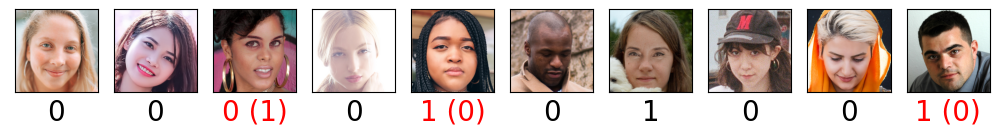

In [14]:
#Small overview of results

def test_overview(model, dataloader, resize = None):
    """Display an overview of the results over the first batch of the dataloader 

    Args:
        model : Trained model
        dataloader: Dataloader
        resize (_type_, optional): Transformation to apply to all images of the batch.
        Defaults to None.
    """
    sigmoid = nn.Sigmoid()
    x_test, y_test,_ = next(iter(dataloader))
    if resize:
        transform = mlp_transform
        x_t = transform(x_test)
    y_pred = model(x_t.squeeze().view(x_t.shape[0],-1).to(device)).cpu()
    y_test = y_test.numpy().astype(int)
    y_pred = torch.round(sigmoid(y_pred)).squeeze(1).detach().numpy().astype(int)
    x_test = x_test.permute(0,2,3,1).numpy()
    plot_images(x_test/255, y_test, range(0,10), columns=12, x_size=1, y_size=1, y_pred=y_pred)
test_overview(model_mlp, test_data_loader, resize=resize)

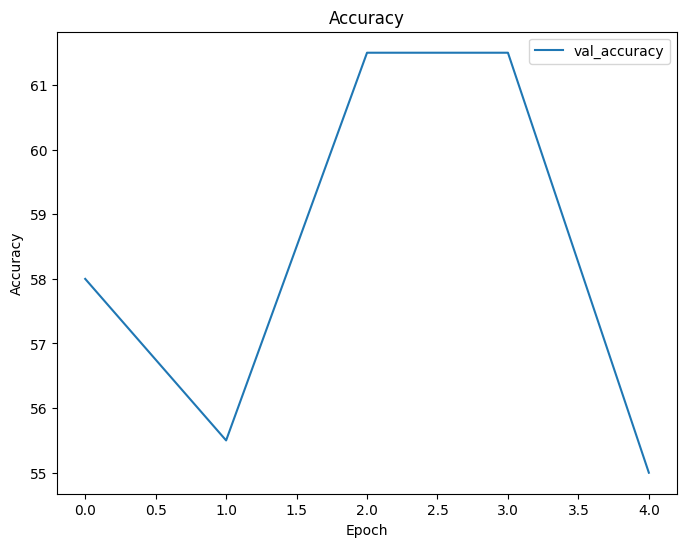

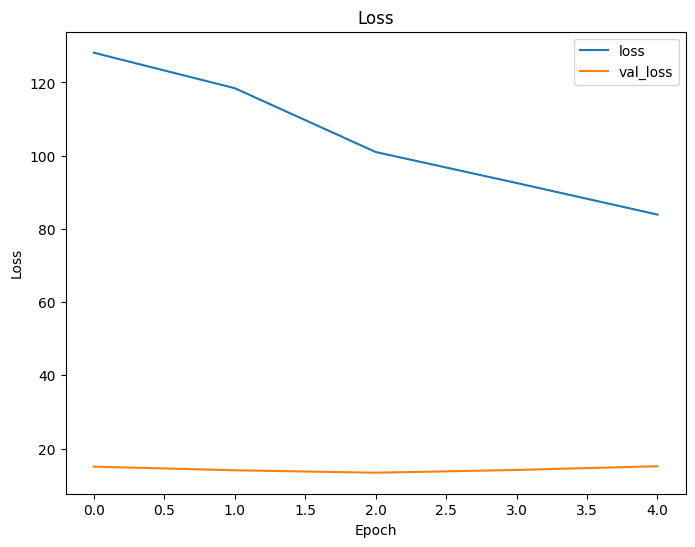

In [15]:
#Plot validation accuracy and loss curves
plot_history(mlp_history)

In [16]:
# Evaluation of the MLP on the test dataloader
print("Accuracy: "+ str(eval_binary_classifier(model_mlp, test_data_loader, loss_fn=loss_fn, 
                       resize = mlp_transform, mlp=True)[1]))

Accuracy: 61.0


- The first model with MLP has bad performance. It does not perform than random selection

## MLP with Data Augmentation

- We will create a dataset by applying a sequence of transformation: HorizontalFlip, Vertical Flip
- Then, we will use ConcatDataset function to add it to the original dataset

In [17]:
applier_dataset = FaceDataset(img_dir_tr,label_bin_tr,label_tr,
                            transform=applier)
train_app_dataset = ConcatDataset([train_dataset, applier_dataset])
train_app_data_loader = DataLoader(train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               drop_last=True)

In [18]:
# 
model = MLPClassif(INPUT_SIZE, HIDDEN_SIZE,10, OUTPUT_SIZE)
model.apply(init_weights)

MLPClassif(
  (layer1): Linear(in_features=3600, out_features=4000, bias=True)
  (layer2): Linear(in_features=4000, out_features=4000, bias=True)
  (hidden3): Linear(in_features=4000, out_features=100, bias=True)
  (hidden4): Linear(in_features=100, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
)

In [19]:
model = model.to(device)
learning_rate = 0.001
print('Train on GPU: '+ str(next(model.parameters()).is_cuda))
model_mlp2, mlp_history2 = train_val_binary_classifier(model, 
                                                     train_app_data_loader,
                                                     valid_data_loader,
                                                     EPOCHS,loss_fn,
                                                     learning_rate, 
                                                     verbose=True,
                                                     resize=mlp_transform,
                                                     file_name='mlp_parameters.pt',
                                                     mlp = True)

Train on GPU: False

Epoch [1/5]
Train loss: 122.14383 | Valid loss: 16.68640 | Valid acc: 48.50%


Epoch [2/5]
Train loss: 122.86648 | Valid loss: 13.97084 | Valid acc: 54.50%

Saved new state.

Epoch [3/5]
Train loss: 121.02671 | Valid loss: 13.94562 | Valid acc: 52.50%

Saved new state.

Epoch [4/5]
Train loss: 112.18993 | Valid loss: 13.73620 | Valid acc: 53.00%

Saved new state.

Epoch [5/5]
Train loss: 111.44071 | Valid loss: 14.78325 | Valid acc: 51.00%



In [20]:
print("Accuracy: "+ str(eval_binary_classifier(model_mlp2, test_data_loader, loss_fn=loss_fn, 
                       resize = mlp_transform, mlp=True)[1]))

Accuracy: 52.0


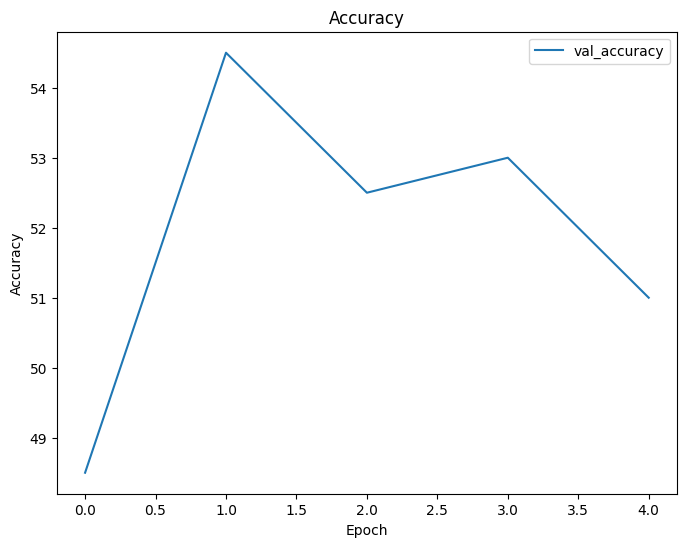

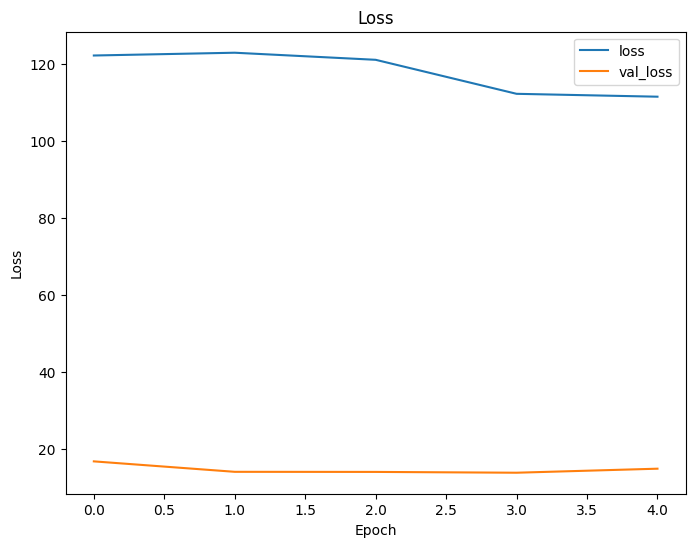

In [21]:
plot_history(mlp_history2)

## MLP with Automatic Data Augmentation from Imagenet

In [22]:
policies = T.AutoAugmentPolicy.IMAGENET
augmenters = T.AutoAugment(policies)
imagenet_data = FaceDataset(img_dir_tr,label_bin_tr,label_tr,
                            transform=augmenters)
train_imagenet_data = ConcatDataset([train_dataset,imagenet_data])
train_imagenet_data_loader = DataLoader(train_imagenet_data, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, 
                               drop_last=True )

In [23]:
model = model = MLPClassif(INPUT_SIZE, HIDDEN_SIZE,10, OUTPUT_SIZE)
model.apply(init_weights)

MLPClassif(
  (layer1): Linear(in_features=3600, out_features=4000, bias=True)
  (layer2): Linear(in_features=4000, out_features=4000, bias=True)
  (hidden3): Linear(in_features=4000, out_features=100, bias=True)
  (hidden4): Linear(in_features=100, out_features=100, bias=True)
  (out_layer): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
  (batchnorm): BatchNorm1d(4000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.25, inplace=False)
)

In [24]:
model = model.to(device)
learning_rate = 0.001
print('Train on GPU: '+ str(next(model.parameters()).is_cuda))
model_mlp3, mlp_history3 = train_val_binary_classifier(model, 
                                                     train_app_data_loader,
                                                     valid_data_loader,
                                                     EPOCHS,loss_fn,
                                                     learning_rate, 
                                                     verbose=True,
                                                     resize=mlp_transform,
                                                     file_name='mlp_parameters.pt',
                                                     mlp = True)

Train on GPU: False

Epoch [1/5]
Train loss: 123.28864 | Valid loss: 14.92535 | Valid acc: 57.50%


Epoch [2/5]
Train loss: 121.55976 | Valid loss: 14.46130 | Valid acc: 48.50%

Saved new state.

Epoch [3/5]
Train loss: 110.59305 | Valid loss: 13.90783 | Valid acc: 55.50%

Saved new state.

Epoch [4/5]
Train loss: 106.42641 | Valid loss: 13.63578 | Valid acc: 56.00%

Saved new state.

Epoch [5/5]
Train loss: 102.30077 | Valid loss: 13.82843 | Valid acc: 59.00%



In [25]:
print("Accuracy: "+ str(eval_binary_classifier(model_mlp3, test_data_loader, loss_fn=loss_fn, 
                       resize = mlp_transform, mlp=True)[1]))

Accuracy: 61.5


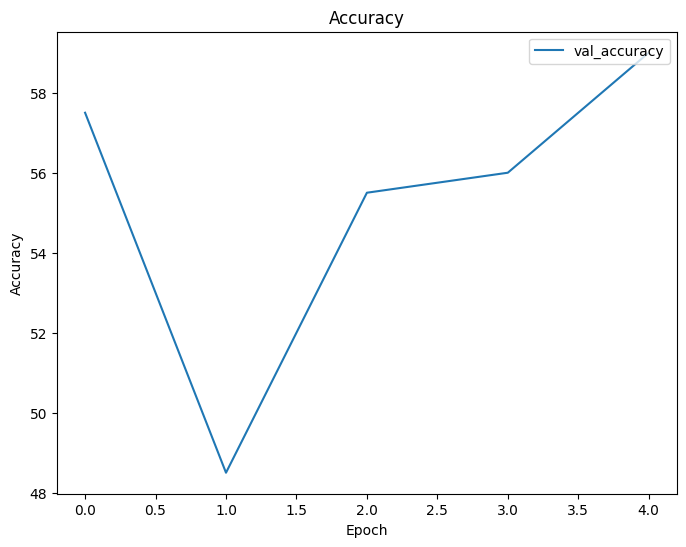

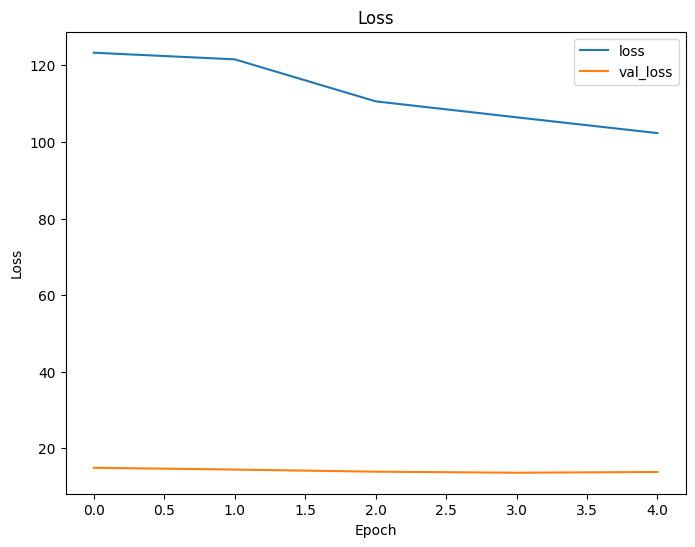

In [27]:
plot_history(mlp_history3)

# CNN

In [26]:
class CNN(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32,num_channels3 = 64, num_classes=1):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels= num_channels1, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels1, affine=False),
                           nn.MaxPool2d(kernel_size=2))

        
        self.layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels2,affine=False),
                           nn.AvgPool2d(kernel_size=4))
        self.layer3 = nn.Sequential(nn.Conv2d(num_channels2, num_channels3, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels3,affine=False),
                           nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(num_channels3, num_channels1, 
                                                   kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.BatchNorm2d(num_channels1,affine=False),
                           nn.AvgPool2d(kernel_size=4))
        
        self.dropout = nn.Dropout2d(p=0.1)
        self.fc = nn.Linear(144, num_classes)

    def forward(self, x):
        #print(x.shape)
        x = self.layer1(x)
        x=self.dropout(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x=self.layer3(x)
        #out = self.fc(x.view(-1, 32*7*7))
        x=self.layer4(x)
        x= x.reshape(x.size(0), -1)
        #print(x.shape)
        out = self.fc(x)
        return out

## CNN With Original Data

In [30]:
learning_rate = 0.01
# Initialize CNN and train it
model_cnn = CNN()
model_cnn.apply(init_weights)
model_cnn.to(device)
print('Train on GPU: '+ str(next(model_cnn.parameters()).is_cuda))

model_cnn, cnn_history= train_val_binary_classifier(model_cnn, 
                                                train_data_loader,
                                                valid_data_loader, 
                                                EPOCHS,loss_fn, 
                                                learning_rate, 
                                                verbose=True,
                                                file_name='cnn_parameters.pt',
                                                resize=mlp_transform)

Train on GPU: False

Epoch [1/5]
Train loss: 1323.77546 | Valid loss: 113.72794 | Valid acc: 55.50%


Epoch [2/5]
Train loss: 864.08236 | Valid loss: 27.09496 | Valid acc: 46.50%

Saved new state.

Epoch [3/5]
Train loss: 535.54120 | Valid loss: 166.07989 | Valid acc: 46.50%


Epoch [4/5]
Train loss: 414.56343 | Valid loss: 20.65820 | Valid acc: 53.00%

Saved new state.

Epoch [5/5]
Train loss: 552.22648 | Valid loss: 13.90660 | Valid acc: 53.50%

Saved new state.


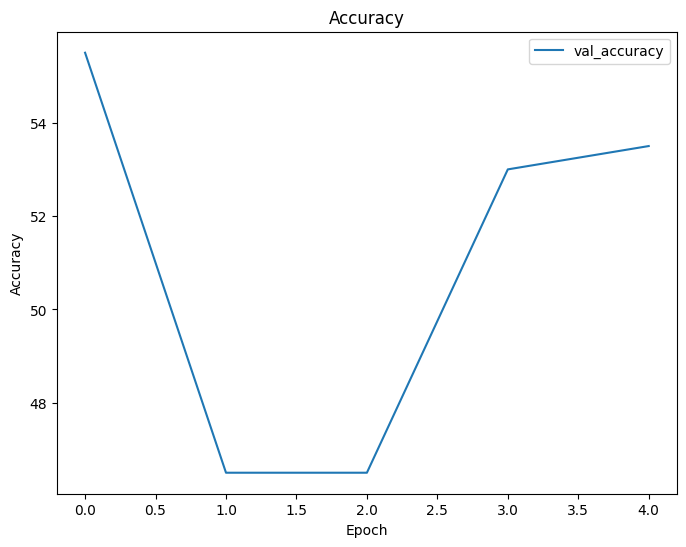

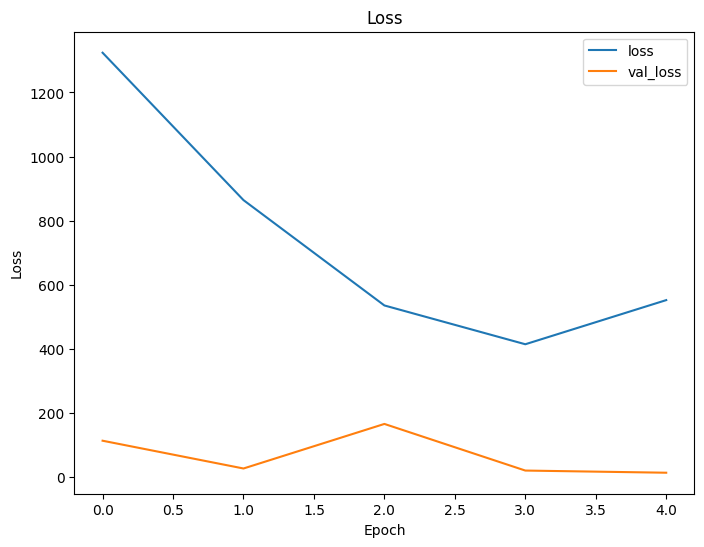

In [31]:
# Plot validation accuracy and loss curves
plot_history(cnn_history)

In [52]:
# Evaluation of the CNN on the test dataloader
print(f"Accuracy: ",
f"{eval_binary_classifier(model_cnn, test_data_loader, loss_fn=loss_fn, resize=mlp_transform)[1]}")

Accuracy:  45.5


In [35]:
def extract_TSNE_embeddings(model, data_loader, train_dataset, batch_size, len_layer,
                        transform=None, mlp = False):
    
    """Compute T-SNE Embeddings"""
    feature_maps_tot = torch.empty((len(train_dataset), len_layer), dtype=torch.float).to(device)
    labels_fm_tot = torch.empty(len(train_dataset), dtype=torch.float)

    model.eval()
    with torch.no_grad():
        for ib, (images, labels) in enumerate(data_loader):
            indices_b = torch.arange(ib*batch_size, (ib+1)*batch_size)
            labels_fm_tot[indices_b] = labels.float()
            if transform:
                images = transform(images)
            if mlp:
                images = images.reshape(images.shape[0], -1)
            out = model.layer1(images.to(device))
            out = model.layer2(out)
            feats_vec = out.reshape(batch_size, -1)
            feature_maps_tot[indices_b, :] = feats_vec

    feature_maps_tot = feature_maps_tot.cpu().numpy()
    labels_fm_tot = labels_fm_tot.numpy()
    print('Size of vectorized feature maps:', feature_maps_tot.shape)
    print('Size of the tensor storing labels:', labels_fm_tot.shape)
    feature_maps_TSNE = TSNE(n_components=2, init='pca').fit_transform(feature_maps_tot)
    print('Size TSNE embeddings (feature maps):', feature_maps_TSNE.shape)
    return feature_maps_TSNE, labels_fm_tot

In [ ]:
tsne_embeddings_mlp = extract_TSNE_embeddings(model_mlp, train_data_loader,
                                       train_dataset, BATCH_SIZE, len_layer = HIDDEN_SIZE, transform = resize,
                                       mlp = True
                                       )
plot_embeddings(tsne_embeddings_mlp[0], tsne_embeddings_mlp[1], "MLP")

## CNN With Data Augmentation

In [36]:
learning_rate = 0.01
# Initialize CNN and train it
model_cnn = CNN()
model_cnn.apply(init_weights)
model_cnn.to(device)
print('Train on GPU: '+ str(next(model_cnn.parameters()).is_cuda))

model_cnn2, cnn_history2= train_val_binary_classifier(model_cnn, 
                                                train_data_loader,
                                                valid_data_loader, 
                                                EPOCHS,loss_fn, 
                                                learning_rate, 
                                                verbose=True,
                                                file_name='cnn_parameters.pt',
                                                resize=mlp_transform)

Train on GPU: False

Epoch [1/5]
Train loss: 1395.91414 | Valid loss: 202.09014 | Valid acc: 52.50%


Epoch [2/5]
Train loss: 365.54955 | Valid loss: 22.89035 | Valid acc: 46.50%

Saved new state.

Epoch [3/5]
Train loss: 213.09670 | Valid loss: 38.87462 | Valid acc: 47.50%


Epoch [4/5]
Train loss: 236.40441 | Valid loss: 13.78782 | Valid acc: 59.00%

Saved new state.

Epoch [5/5]
Train loss: 208.94071 | Valid loss: 18.51497 | Valid acc: 55.00%



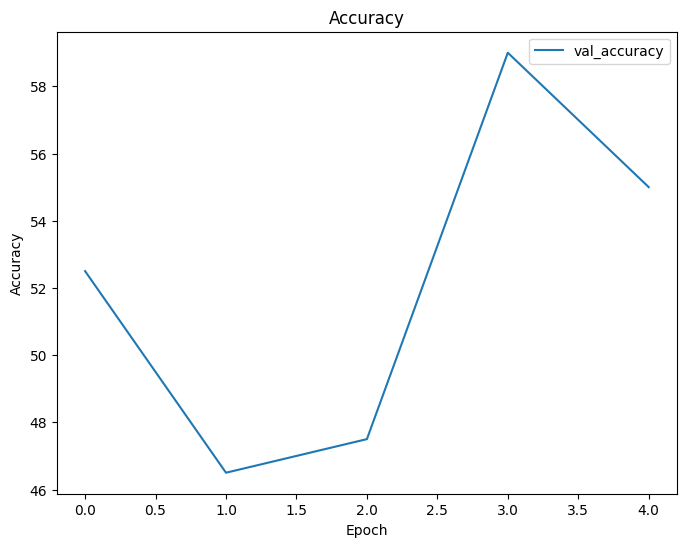

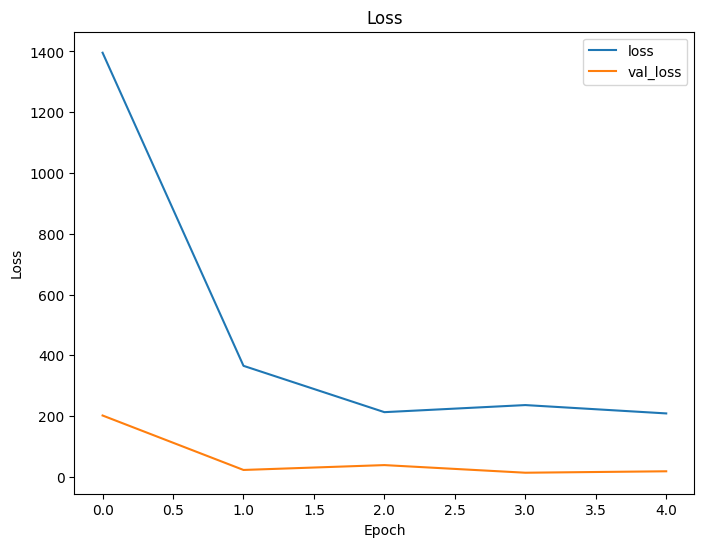

In [37]:
plot_history(cnn_history2)

In [47]:
print(f"Accuracy: ",
f"{eval_binary_classifier(model_cnn2, test_data_loader, loss_fn=loss_fn, resize=mlp_transform)[1]}")

Accuracy:  47.5


In [ ]:
tsne_embeddings_cnn = extract_TSNE_embeddings(model_cnn, train_data_loader,
                                       train_dataset, BATCH_SIZE, len_layer = 7200, transform = resize,
                                       
                                       )
plot_embeddings(tsne_embeddings_cnn[0], tsne_embeddings_cnn[1], 'CNN')

# Transfert learning with MobilenetV2

In [49]:
import torchvision.models as models

def build_model(name, fine_tune=True, num_classes=1):

    assert name in ("mobilenetv2", "efficientnet_b0")

    print('[INFO]: Loading pre-trained weights')
    if name =="mobilenetv2":
        model = models.mobilenet_v2(weights="DEFAULT")
    else:

        model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

In [50]:
model = build_model(name="mobilenetv2", fine_tune=True, num_classes=1)
mobilenet_transform = T.Compose([T.Resize(size = [224,224]),
                 T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...


In [51]:
learning_rate = 0.001
mobilenet, mobilenet_history= train_val_binary_classifier(model, 
                                                train_data_loader,valid_data_loader, 
                                                EPOCHS,loss_fn, learning_rate, verbose=True,
                                                file_name='cnn_parameters.pt',
                                                resize=mobilenet_transform)


Epoch [1/5]
Train loss: 111.35103 | Valid loss: 13.49747 | Valid acc: 58.50%


Epoch [2/5]
Train loss: 112.28156 | Valid loss: 14.49366 | Valid acc: 47.00%


Epoch [3/5]
Train loss: 113.12217 | Valid loss: 13.98564 | Valid acc: 47.00%


Epoch [4/5]
Train loss: 112.80336 | Valid loss: 13.98954 | Valid acc: 47.50%


Epoch [5/5]
Train loss: 112.75876 | Valid loss: 14.06749 | Valid acc: 47.00%



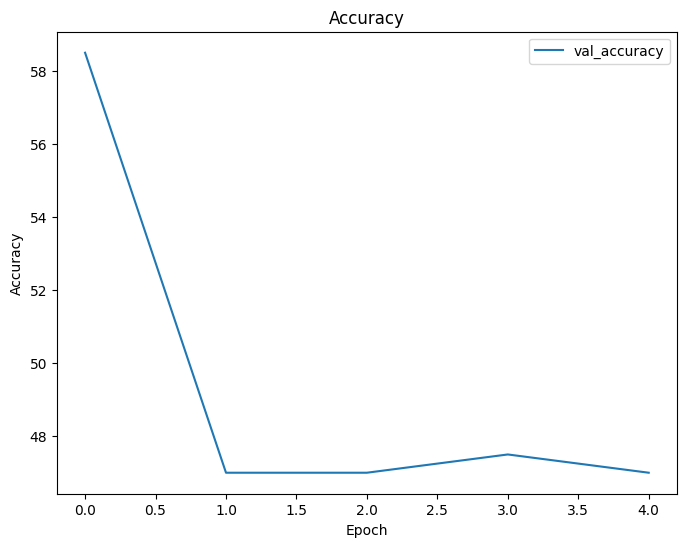

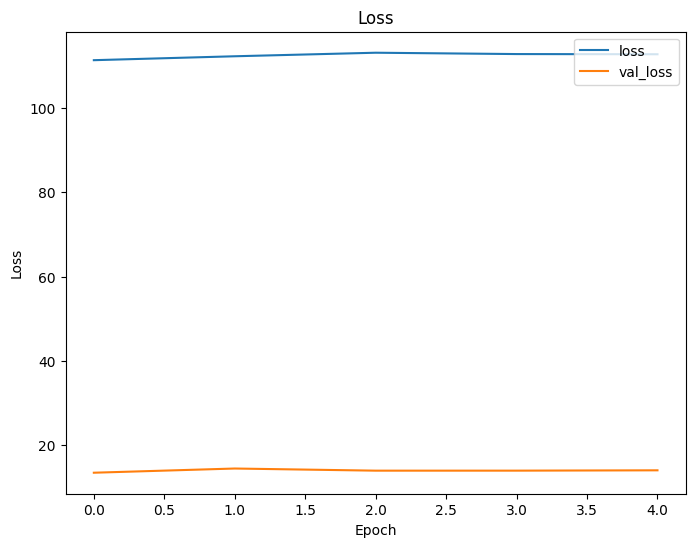

In [53]:
plot_history(mobilenet_history)